# Variational Autoencoders

During the lecture we saw that sometimes our data are not labeled. In those cases, we use unsupervised learning to learn underlying hidden distribution of the dataset. These models called deep generative models can be used to reduce data into its fundamental features, or to generate new samples from same distributions. We also saw that generative models are classified in two types:

- **Explicit density**: An explicit model learns the data distribution from the sample distribution

- **Implicit density**: An implicit model don’t learn the distribution of the data, but rather learns the statistical properties of the data.

In this notebook, we will implement a generative model of explicit type: VAEs.

A classical image autoencoder takes an image, maps it to a latent vector space via an "encoder" module, then decode it back to an output with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the same images as the input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

In practice, such classical autoencoders do not lead to particularly useful or well-structured latent spaces. They are not particularly good at compression, either. For these reasons, they have largely fallen out of fashion over the past years. Variational autoencoders, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a very powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed "code" in the latent space, turns the image into the parameters of a statistical distribution: a *mean* and a *variance*. Essentially, this means that we are assuming that the input image has been generated by a statistical process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every point sampled in the latent will be decoded to a valid output.

**In technical terms, here is how a variational autoencoder works:**

First, an encoder module turns the input samples `input_img` into two parameters in a latent space of representations, which we will note `z_mean` and `z_log_variance`. 

Then, we randomly sample a point `z` from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values. 

Finally, a decoder module will map this point in the latent space back to the original input image. Because `epsilon` is random, the process ensures that every point that is close to the latent location where we encoded `input_img` (`z-mean`) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. 

Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus, highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: 
- A reconstruction loss that forces the decoded samples to match the initial inputs
- A regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

**Let's go over a Keras [implementation](https://blog.keras.io/building-autoencoders-in-keras.html) of a VAE. Schematically, it looks like this:**

````
# Encode the input into a mean and variance parameter
z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
reconstructed_img = decoder(z)

# Instantiate a model
# with input the original input images, output reconstructed images
model = Model(input_img, reconstructed_img)

# Then, train the model using 2 losses:
# a reconstruction loss and a regularization loss
````

In this tutorial, we will implement a VAE for the MNIST dataset. Our goal can be summarized in the following image:

![VAE_MNIST](./VAE_MNIST.PNG)

*Image taken from : https://blog.keras.io/building-autoencoders-in-keras.html*

**Build the encoder network in this way (it is a simple convnet which maps the input image`x` to two vectors, `z_mean` and `z_log_variance`).**

- Convolution layer of size 32, with 3x3 kernel and ReLU activation function;
- Convolution layer of size 64, with 3x3 kernel, stride 2x2 and ReLU activation function;
- Convolution layer of size 64, with 3x3 kernel, and ReLU activation function;
- Convolution layer of size 64, with 3x3 kernel, and ReLU activation function;
- Flatten layer;
- Fully Connected layer of size 32 with ReLU activation function;
- Fully Connected layer of size `latent_dim` (assign the result of this to a variable called `z_mean`)
- Fully Connected layer of size `latent_dim` (assign the result of this to a variable called `z_log_var`)

*Use a functional model definition*

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 128
latent_dim = 10  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# mapping inputs to our latent distribution parameters z_mean and z_log_var
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)


Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a Sampling layer which parent is the base layer class [layer](https://keras.io/api/layers/base_layer/). In Keras, everything needs to be a layer, so arbitrary layers that are not part of the API, should be defined as new classes.

In [2]:
class Sampling(layers.Layer):
    """Uses [z_mean, z_log_var] to sample z, the vector encoding a digit."""

    def call(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1] #latent_dim
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
# add a layer sampling to the encoder model  
z = Sampling()([z_mean, z_log_var])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


**Build an encoder model:**

In [3]:
encoder = keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")

#print summary
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

**Build the decoder network in this way:**
- Upsample to the correct number of units
- Reshape into an image of the same shape as before our last `Flatten` layer
- Apply the reverse operation to the initial stack of convolution layers (deconvolution): a [`Conv2DTranspose` layer](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) with corresponding parameters
- Convolutional layer, 1 filter of dimension 3x3 with `sigmoid` activation function

We end up with a feature map of the same size as of the original input.

*This is the decoder implementation:*

We reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`.

In [4]:
# This is the input where we will feed `z`.
print("Latent vector shape", K.int_shape(z)[1:])

decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

# This is our decoder model.
decoder = Model(decoder_input, x, name='Decoder')

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

#print model summary
decoder.summary()

Latent vector shape (10,)
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             137984    
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 156,737
Trainable params: 156,737
Non-trainable params: 0
_________________________________________________________________


The dual loss of a VAE does not fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up the loss by writing a [custom model](https://keras.io/api/models/model/) with internally leverages the built-in Model class and that overwrittes the method `train_step`

We are going to use three functions from Tensorflow directly which are not in the Keras API:
- [GradienTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)

- [Reduce_sum](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum)

- [Reduce_mean](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean)

**Create a VAE class model**

In [5]:
import tensorflow as tf # for using GradientTape, reduce_mean, reduce_sum

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # reconstruction loss
        # the decoded samples should match the initial input images
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        # regularization loss
        # to learn well-formed latent spaces and reduce overfitting
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        # regularization + reconstruction
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # Overwrite the train_setp method, to redefine what the fit funtion does.
        # this is needed to dealk with custom loss functions
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_decoded = self.decoder(z)
            
            # calculate losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, z_decoded), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # sum losses
            total_loss = reconstruction_loss + kl_loss
            
        # Calculate the gradient and update the weights (Backward pass)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # update loss metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, we do not specify an external loss at compile time (loss=None), which in turns means that we won't pass target data during training (as you can see we only pass `x_train` to the model in fit).

**Create a VAE model instance and pass `encoder` and `decoder`.**

In [6]:
# Instantiate a VAE object
vae = VAE(encoder, decoder)

# Configure it
vae.compile(optimizer='rmsprop', loss=None)

**Import the MNIST dataset from Keras. Remember that we do not use the training labels! Perform some data pre-processing: use `astype('float32')` and then `reshape`.**

In [7]:
from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

**Fit the VAE model with N epochs**

*This will take a while ...*

In [8]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=1,
        batch_size=batch_size)


469/469 [==============================] - 148s 316ms/step - loss: 238.4301 - reconstruction_loss: 184.3731 - kl_loss: 10.4481


Once such a model is trained -- e.g. on MNIST, in our case -- we can use the decoder network to turn arbitrary latent space vectors into images:

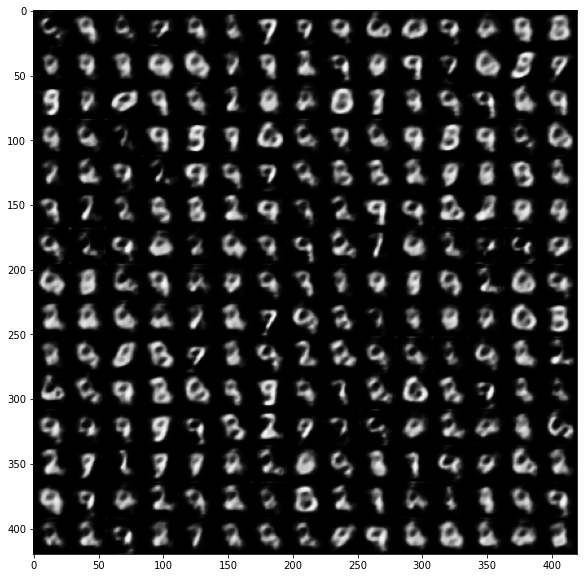

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Randomly sample from 10-D latent space and decode it to 28*28 image
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.random.normal(loc = 0, scale = 1.0, size = (10))
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 10)
        x_decoded = vae.decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits shows randomly sampled images from learned latent representation.

### T-SNE Visualization

Now, we will use **T-SNE** for visualiazation of reduced dimensionality.
Here we reduce from 10 dimensional latent space to 2-D.

Detailed information of t-sne can be looked up [here](https://lvdmaaten.github.io/tsne/).


The basic idea of **T-SNE** is covered in the lecture for dimensionality reduction.
We use the **T-SNE** implementation of Scikit-learn. Here the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [10]:
from sklearn.manifold import TSNE

encoder = Model(input_img, z_mean)
encoded_input = encoder.predict(x_test)
latent_space = TSNE(n_components=2).fit_transform(encoded_input)

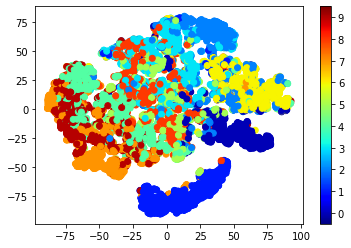

In [11]:
tsne_x = latent_space[:,0]
tsne_y = latent_space[:,1]
plt.scatter(tsne_x, tsne_y, c=y_test, cmap=plt.cm.get_cmap("jet"))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

*Note: We just trained 1 epoch to speed up the training. But you can improve the results, training for more epochs!*